In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow
print(tensorflow.__version__)

2.5.0


In [ ]:
!pip3 install 'h5py==2.10.0' --force-reinstall

     |████████████████████████████████| 2.9MB 26.0MB/s 
     |████████████████████████████████| 15.3MB 199kB/s 
ERROR: lucid 0.3.10 requires umap-learn, which is not installed.
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.4.0 which is incompatible.
ERROR: lucid 0.3.10 has requirement numpy<=1.19, but you'll have numpy 1.20.3 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Found existing installation: numpy 1.19.5
    Uninstalling 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ~

/root


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/PConv-Keras

/content/drive/MyDrive/Colab Notebooks/PConv-Keras


In [ ]:
import os
import gc
import copy

import numpy as np
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback

import matplotlib
import matplotlib.pyplot as plt

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')

from libs.util import MaskGenerator
from libs.pconv_model import PConvUnet

# Settings
BATCH_SIZE = 4

# Imagenet Rescaling
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [ ]:
PConvUnet().summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

tracking <tf.Variable 'p_conv2d_1/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_2/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_3/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_4/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_5/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_6/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_7/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_8/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_9/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_10/Variable:0' shape=(3, 

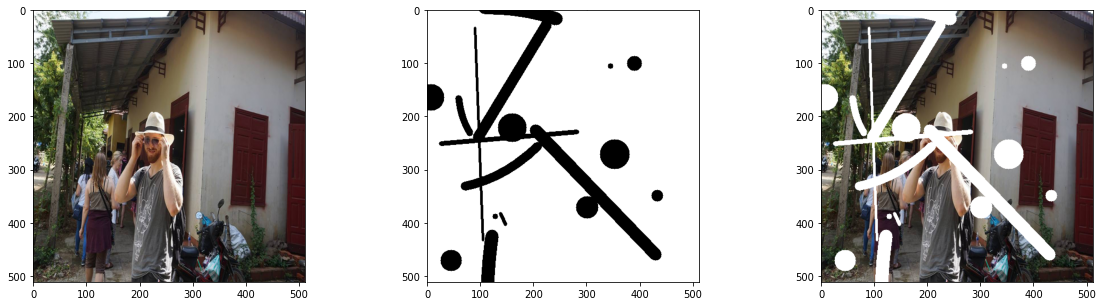

In [ ]:
# Instantiate mask generator
mask_generator = MaskGenerator(512, 512, 3, rand_seed=42)

# Load image
img = np.array(Image.open('./data/sample_image.jpg').resize((512, 512))) / 255

# Load mask
mask = mask_generator.sample()

# Image + mask
masked_img = copy.deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

In [ ]:
def plot_sample_data(masked, mask, ori, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[:,:,:])
    axes[0].set_title('Masked Input')
    axes[1].imshow(mask[:,:,:])
    axes[1].set_title(middle_title)
    axes[2].imshow(ori[:,:,:])
    axes[2].set_title('Target Output')
    plt.show()

class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([mask_generator.sample() for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = copy.deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy array
batch = np.stack([img for _ in range(BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=BATCH_SIZE)

In [ ]:
generator

<generator object DataGenerator.flow at 0x7fd2af3ebad0>

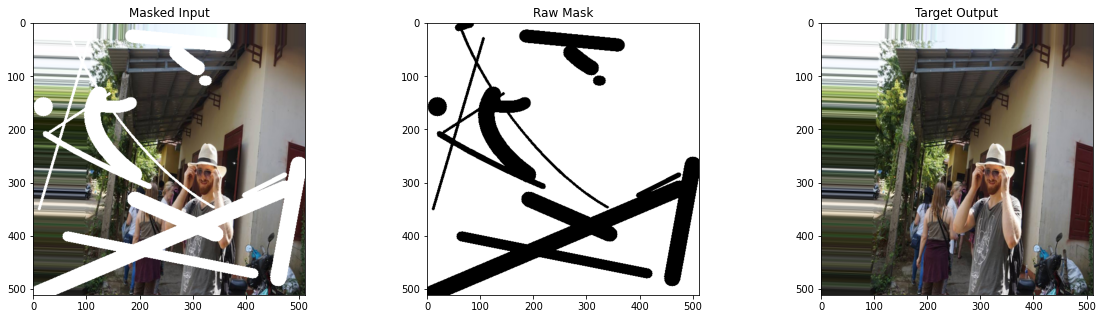

In [ ]:
[m1, m2], o1 = next(generator)
plot_sample_data(m1[0], m2[0]*255, o1[0])

In [ ]:
# Instantiate model
model = PConvUnet(vgg_weights='./data/logs/pytorch_to_keras_vgg16.h5')

tracking <tf.Variable 'p_conv2d_17/Variable:0' shape=(7, 7, 3, 64) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_18/Variable:0' shape=(5, 5, 64, 128) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_19/Variable:0' shape=(5, 5, 128, 256) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_20/Variable:0' shape=(3, 3, 256, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_21/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_22/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_23/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_24/Variable:0' shape=(3, 3, 512, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_25/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_26/Variable:0' shape=(3, 3, 1024, 512) dtype=float32> kernel_mask
tracking <tf.Variable 'p_conv2d_

Epoch 1/10
1000/1000 [==============================] - 1320s 1s/step - loss: 4.7715 - PSNR: 13.5948



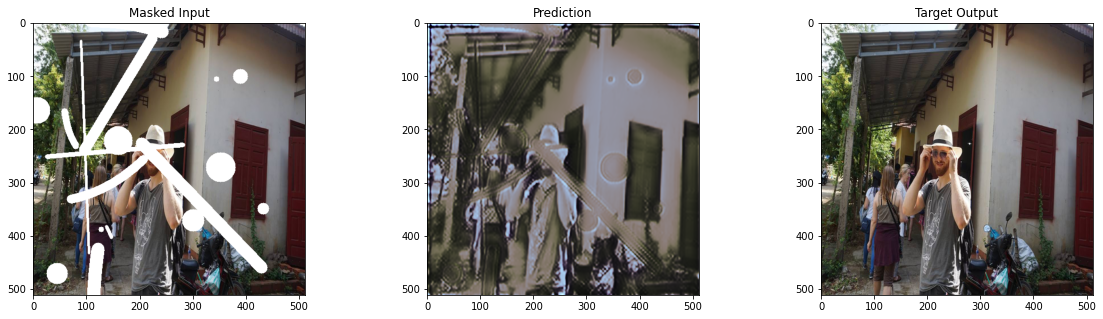

Epoch 2/10
1000/1000 [==============================] - 1322s 1s/step - loss: 2.9926 - PSNR: 17.8446


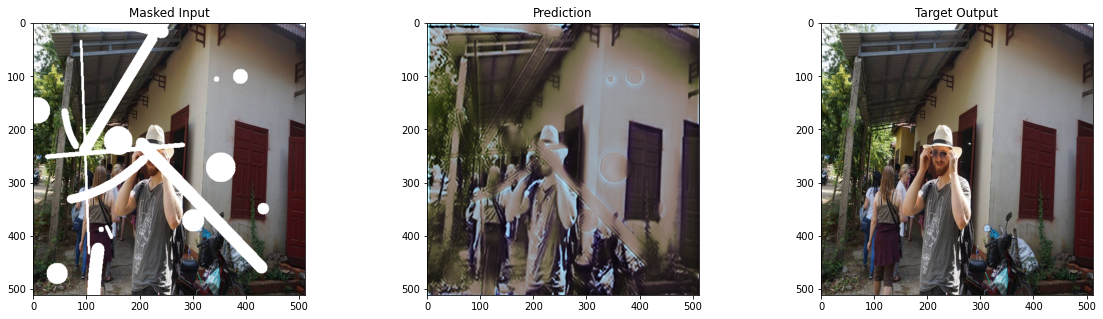

Epoch 3/10
1000/1000 [==============================] - 1325s 1s/step - loss: 2.5133 - PSNR: 19.2129


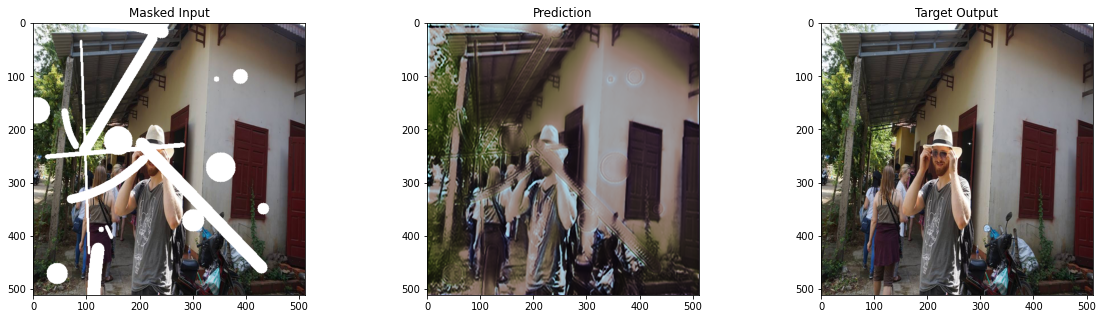

Epoch 4/10
1000/1000 [==============================] - 1326s 1s/step - loss: 2.2478 - PSNR: 19.9609


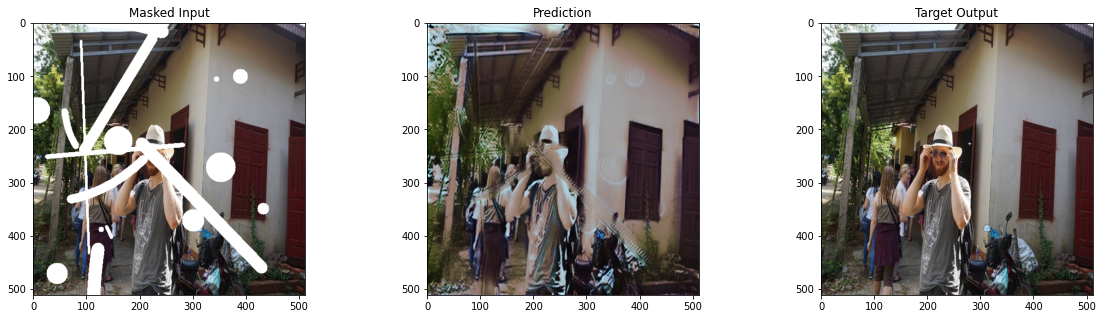

Epoch 5/10
1000/1000 [==============================] - 1327s 1s/step - loss: 2.0289 - PSNR: 20.4080


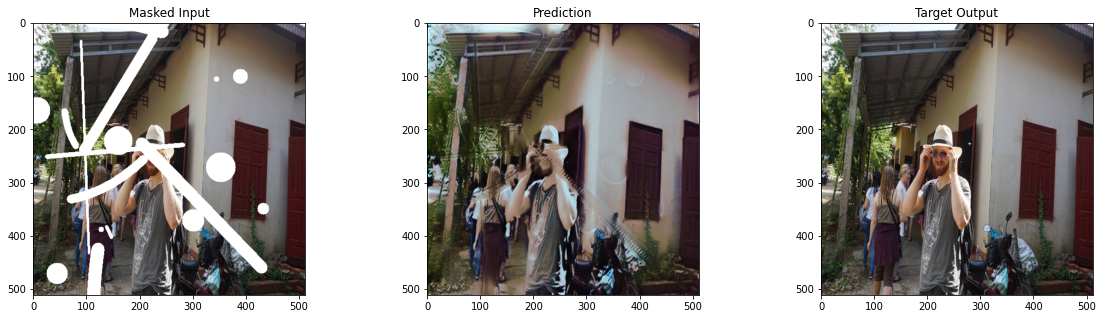

Epoch 6/10
1000/1000 [==============================] - 1328s 1s/step - loss: 1.8785 - PSNR: 20.6703


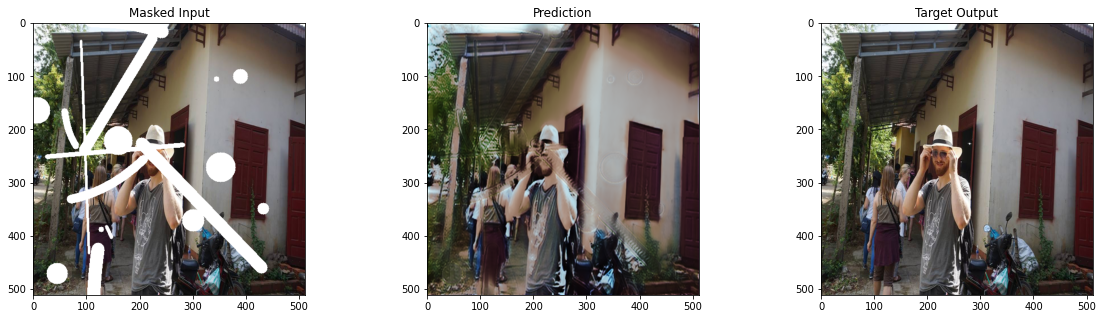

Epoch 7/10
1000/1000 [==============================] - 1327s 1s/step - loss: 1.7565 - PSNR: 20.8820


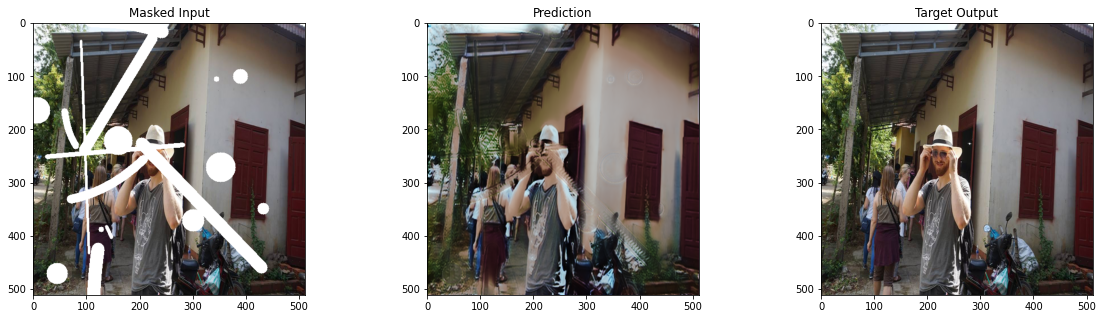

Epoch 8/10
1000/1000 [==============================] - 1328s 1s/step - loss: 1.6668 - PSNR: 21.0908


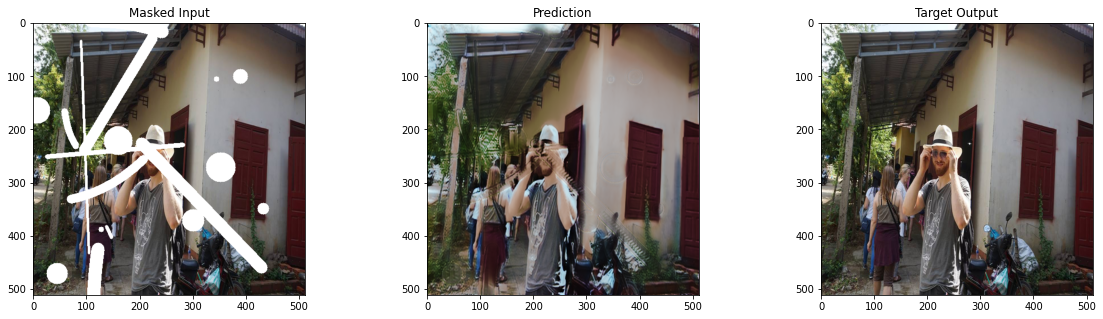

Epoch 9/10
1000/1000 [==============================] - 1329s 1s/step - loss: 1.5894 - PSNR: 21.2852


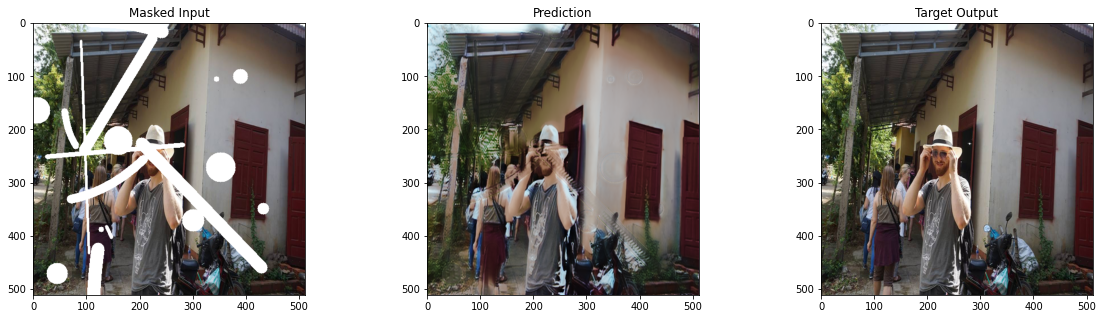

Epoch 10/10
1000/1000 [==============================] - 1330s 1s/step - loss: 1.5349 - PSNR: 21.4726


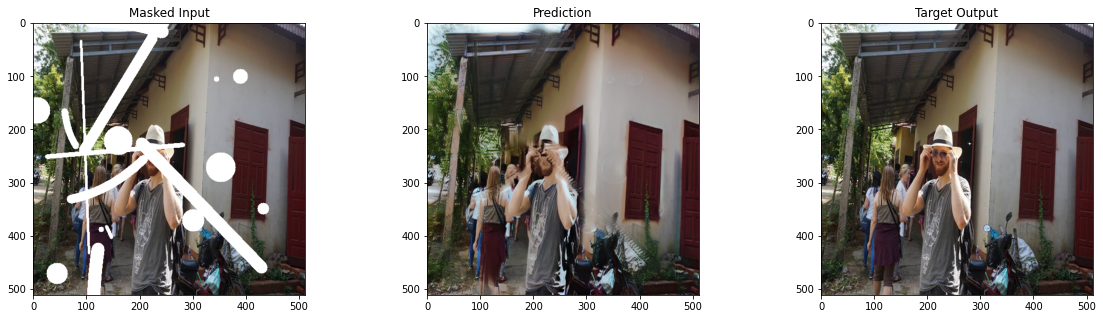

In [ ]:
model.fit_generator(
    generator, 
    steps_per_epoch=1000,
    epochs=10,
    callbacks=[
        TensorBoard(
            log_dir='./data/logs/single_image_test',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/logs/single_image_test/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0), 
                        np.expand_dims(mask,0)
                    ]
                )[0]
                , 
                img,
                middle_title='Prediction'
            )
        )
    ],
)